In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
# import scanpy.api as sc
import scanpy as sc
from igraph import *
# from MulticoreTSNE import MulticoreTSNE as TSNE #faster TSNE alternative
from anndata import read_h5ad
from anndata import read_csv
# import bbknn
# sc.logging.print_versions()

In [2]:
from MCML.modules import MCML, bMCML

from sklearn.manifold import TSNE

# Import DROPLET raw data

In [3]:
pwd

'/home/ec2-user/SageMaker/tabula-muris-senis/1_tabula_muris_senis/11_figure_1'

In [4]:
adata = read_h5ad('/home/ec2-user/SageMaker/data/Data-objects/tabula-muris-senis-droplet-official-raw-obj.h5ad')
adata

AnnData object with n_obs × n_vars = 245389 × 20138
    obs: 'age', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation'
    var: 'n_cells'

In [5]:
# adata.write_loom('./write/maca-droplet-raw.loom')

In [6]:
adata.shape

(245389, 20138)

In [7]:
type(adata.X)

scipy.sparse.csr.csr_matrix

In [8]:
adata.obs.tail()

,age,cell,cell_ontology_class,cell_ontology_id,free_annotation,method,mouse.id,n_genes,sex,subtissue,tissue,tissue_free_annotation
index,,,,,,,,,,,,
10X_P8_15_TTTGTCAGTACATGTC-1,3m,10X_P8_15_TTTGTCAGTACATGTC,basal epithelial cell of tracheobronchial tree,CL:0000066,nan,droplet,3-M-7/8,NaN,male,nan,Trachea,Trachea
10X_P8_15_TTTGTCAGTGCGCTTG-1,3m,10X_P8_15_TTTGTCAGTGCGCTTG,mesenchymal progenitor cell,CL:0008019,nan,droplet,3-M-7/8,NaN,male,nan,Trachea,Trachea
10X_P8_15_TTTGTCAGTTGTCGCG-1,3m,10X_P8_15_TTTGTCAGTTGTCGCG,endothelial cell,CL:0000115,nan,droplet,3-M-7/8,NaN,male,nan,Trachea,Trachea
10X_P8_15_TTTGTCATCGGCTTGG-1,3m,10X_P8_15_TTTGTCATCGGCTTGG,endothelial cell,CL:0000115,nan,droplet,3-M-7/8,NaN,male,nan,Trachea,Trachea
10X_P8_15_TTTGTCATCTTGTTTG-1,3m,10X_P8_15_TTTGTCATCTTGTTTG,chondrocyte,CL:0008019,nan,droplet,3-M-7/8,NaN,male,nan,Trachea,Trachea


In [9]:
set(adata.obs['tissue'])

{'Bladder',
 'Fat',
 'Heart_and_Aorta',
 'Kidney',
 'Large_Intestine',
 'Limb_Muscle',
 'Liver',
 'Lung',
 'Mammary_Gland',
 'Marrow',
 'Pancreas',
 'Skin',
 'Spleen',
 'Thymus',
 'Tongue',
 'Trachea'}

# Preprocessing

In [10]:
sc.pp.filter_genes(adata, min_cells=5)
sc.pp.filter_cells(adata, min_genes=500)
adata

AnnData object with n_obs × n_vars = 242748 × 19734
    obs: 'age', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation'
    var: 'n_cells'

add the total counts per cell as observations-annotation to adata

In [11]:
adata.obs['n_counts'] = np.sum(adata.X, axis=1).A1
adata

AnnData object with n_obs × n_vars = 242748 × 19734
    obs: 'age', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation', 'n_counts'
    var: 'n_cells'

In [12]:
adata = adata[adata.obs['n_counts']>=3000]
adata

View of AnnData object with n_obs × n_vars = 219070 × 19734
    obs: 'age', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation', 'n_counts'
    var: 'n_cells'

In [13]:
# axs = sc.pl.violin(adata, ['n_genes', 'n_counts'],jitter=0.4, multi_panel=True)

# axs = sc.pl.violin(adata[adata.obs['age']=='3m'], ['n_genes', 'n_counts'],
#                    jitter=0.4, multi_panel=True)

# axs = sc.pl.violin(adata[adata.obs['age']!='3m'], ['n_genes', 'n_counts'],
#                    jitter=0.4, multi_panel=True)

# ax = sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [14]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4) #simple lib size normalization?
adata.raw = adata

/home/ec2-user/anaconda3/envs/mxnet_latest_p37/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:524: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key_n_counts] = counts_per_cell


In [15]:
adata = sc.pp.filter_genes_dispersion(adata, subset = False, min_disp=.5, max_disp=None, 
                              min_mean=.0125, max_mean=10, n_bins=20, n_top_genes=None, 
                              log=True, copy=True)
adata

AnnData object with n_obs × n_vars = 219070 × 19734
    obs: 'age', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation', 'n_counts'
    var: 'n_cells', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'

In [16]:
sc.pp.log1p(adata)

In [17]:
sc.pp.scale(adata, max_value=10, zero_center=False)

In [18]:
adata

AnnData object with n_obs × n_vars = 219070 × 19734
    obs: 'age', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation', 'n_counts'
    var: 'n_cells', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'mean', 'std'
    uns: 'log1p'

# Dim red

In [19]:
from sklearn.decomposition import TruncatedSVD

In [20]:
%%time
svd = TruncatedSVD(n_components=64, n_iter=7, random_state=42)
svd.fit(adata.X[:,:])

CPU times: user 7min 44s, sys: 18.5 s, total: 8min 2s
Wall time: 7min 25s


TruncatedSVD(n_components=64, n_iter=7, random_state=42)

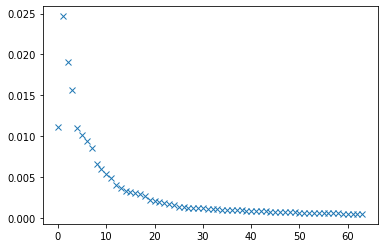

In [21]:
plt.plot(svd.explained_variance_ratio_,'x')

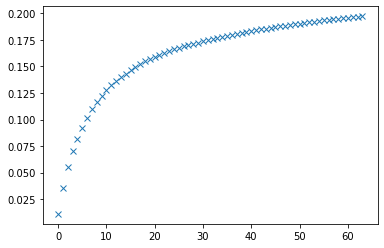

In [22]:
plt.plot(np.cumsum(svd.explained_variance_ratio_),'x')

In [23]:
asvd = svd.transform(adata.X)

In [24]:
np.shape(asvd)

(219070, 64)

In [25]:
import matplotlib.colors as mcolors
colors1 = plt.cm.tab20(np.linspace(0., 1, 20))
colors2 = plt.cm.tab10(np.linspace(0, 1, 10))
colors = np.vstack((colors1, colors2))
tab30 = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

In [26]:
import pacmap

In [27]:

embedding = pacmap.PaCMAP(n_components=2, n_neighbors=15, MN_ratio=0.5, FP_ratio=2.0,apply_pca=False) 

# embedding = pacmap.PaCMAP(n_components=2, n_neighbors=15, MN_ratio=3, FP_ratio=.5,apply_pca=False) 

/home/ec2-user/anaconda3/envs/mxnet_latest_p37/lib/python3.7/site-packages/pacmap/pacmap.py:794: UserWarning: Running ANNOY Indexing on high-dimensional data. Nearest-neighbor search may be slow!
  "Running ANNOY Indexing on high-dimensional data. Nearest-neighbor search may be slow!")


In [28]:
gindage=adata.obs['age']=='3m'

In [29]:
# fit the data (The index of transformed data corresponds to the index of the original data)
X_transformed = embedding.fit_transform(asvd[gindage,:], init='random')

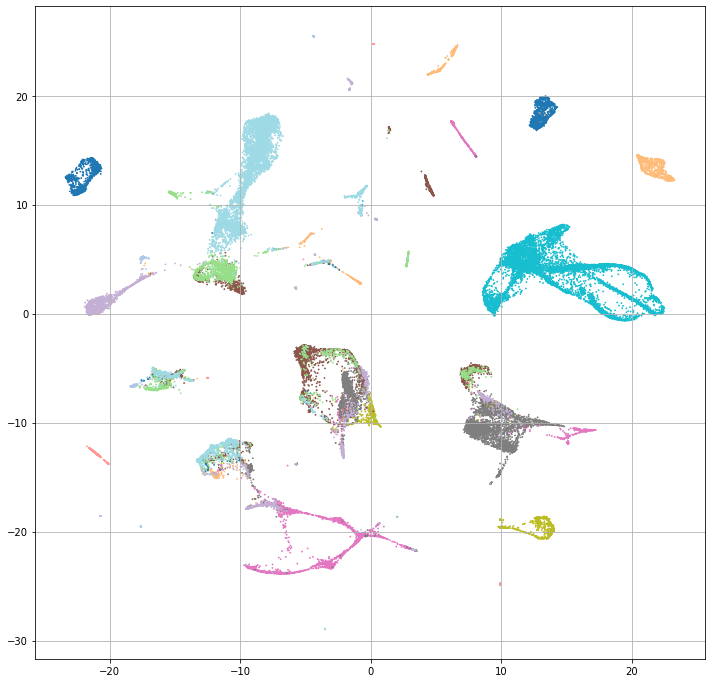

In [30]:
# visualize the embedding
fig, ax = plt.subplots(1, 1, figsize=(12,12))
ax.scatter(X_transformed[:, 0], X_transformed[:, 1], cmap="tab20", c=adata[gindage].obs['tissue'].cat.codes, s=0.6)
plt.grid()

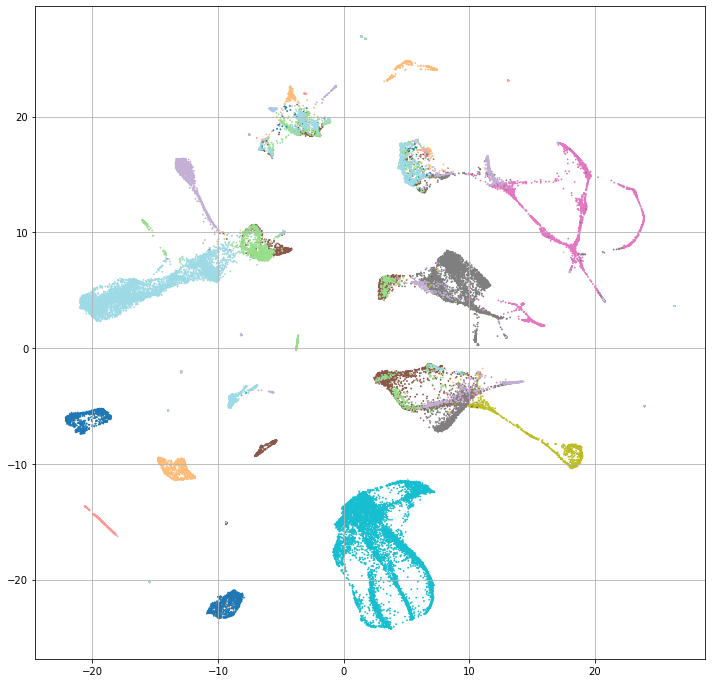

In [29]:
# visualize the embedding
fig, ax = plt.subplots(1, 1, figsize=(12,12))
ax.scatter(X_transformed[:, 0], X_transformed[:, 1], cmap="tab20", c=adata[gindage].obs['tissue'].cat.codes, s=0.6)
plt.grid()

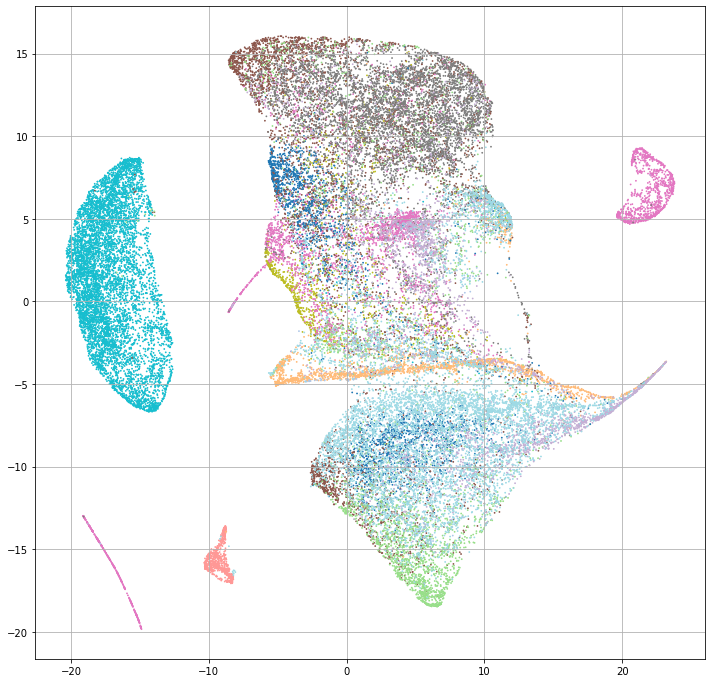

In [31]:
# visualize the embedding
fig, ax = plt.subplots(1, 1, figsize=(12,12))
ax.scatter(X_transformed[:, 0], X_transformed[:, 1], cmap="tab20", c=adata[gindage].obs['tissue'].cat.codes, s=0.6)
plt.grid()

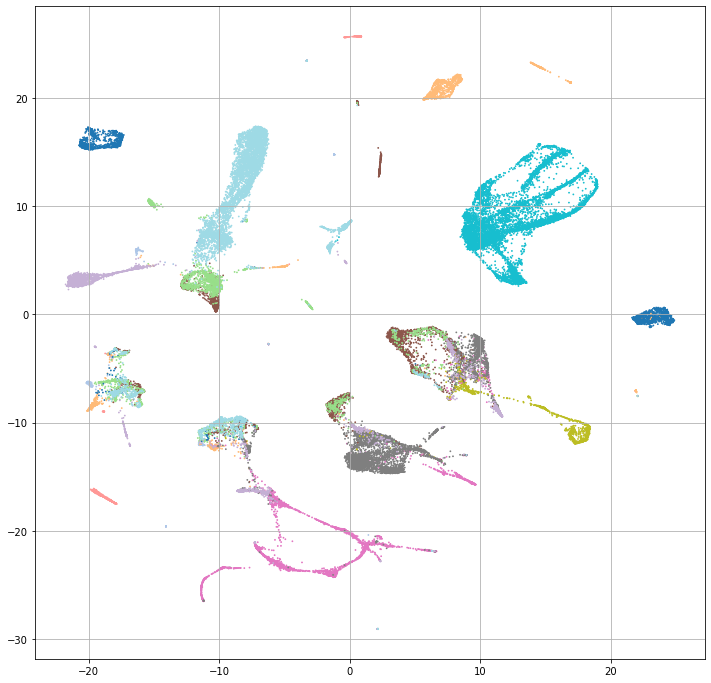

In [30]:
# visualize the embedding
fig, ax = plt.subplots(1, 1, figsize=(12,12))
ax.scatter(X_transformed[:, 0], X_transformed[:, 1], cmap="tab20", c=adata[gindage].obs['tissue'].cat.codes, s=0.6)
plt.grid()

In [50]:
%%time
# fit the data (The index of transformed data corresponds to the index of the original data)

embedding = pacmap.PaCMAP(n_components=2, n_neighbors=15, MN_ratio=0.5, FP_ratio=2.0,apply_pca=False) 
X_transformed = embedding.fit_transform(asvd[:,:], init='random')

CPU times: user 3min 53s, sys: 5.39 s, total: 3min 59s
Wall time: 3min 16s


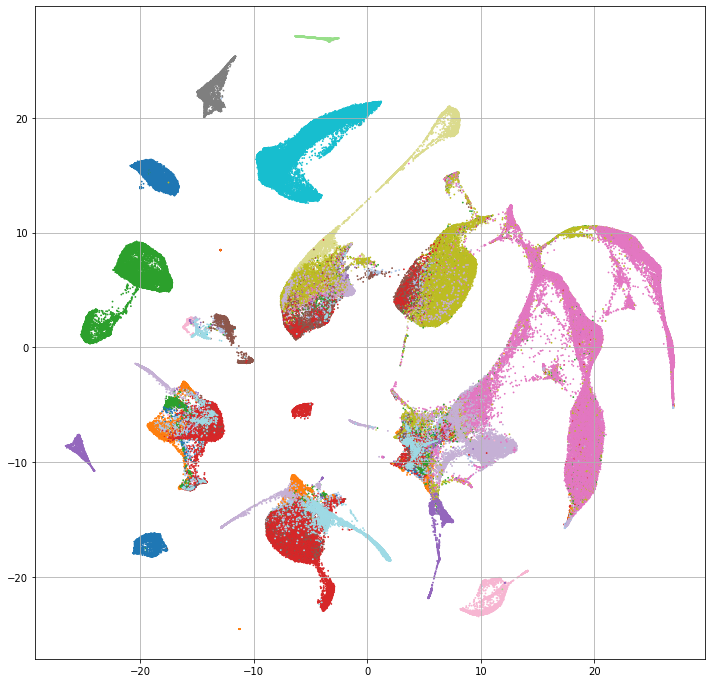

In [79]:
# visualize the embedding
fig, ax = plt.subplots(1, 1, figsize=(12,12))
ax.scatter(X_transformed[:, 0], X_transformed[:, 1], cmap="tab20", c=adata[:].obs['tissue'].cat.codes, s=0.6)
plt.grid()

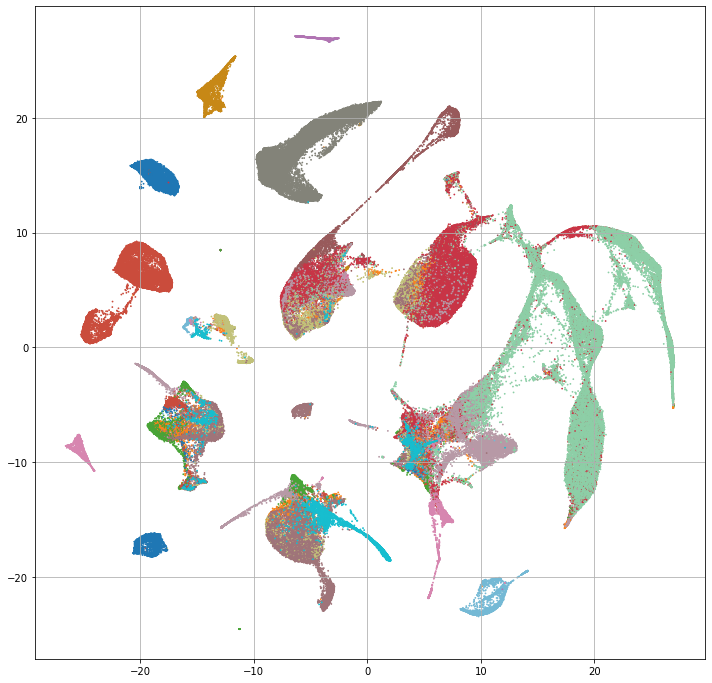

In [78]:
# visualize the embedding
fig, ax = plt.subplots(1, 1, figsize=(12,12))
ax.scatter(X_transformed[:, 0], X_transformed[:, 1], cmap=tab30, c=adata[:].obs['tissue'].cat.codes, s=0.6)
plt.grid()

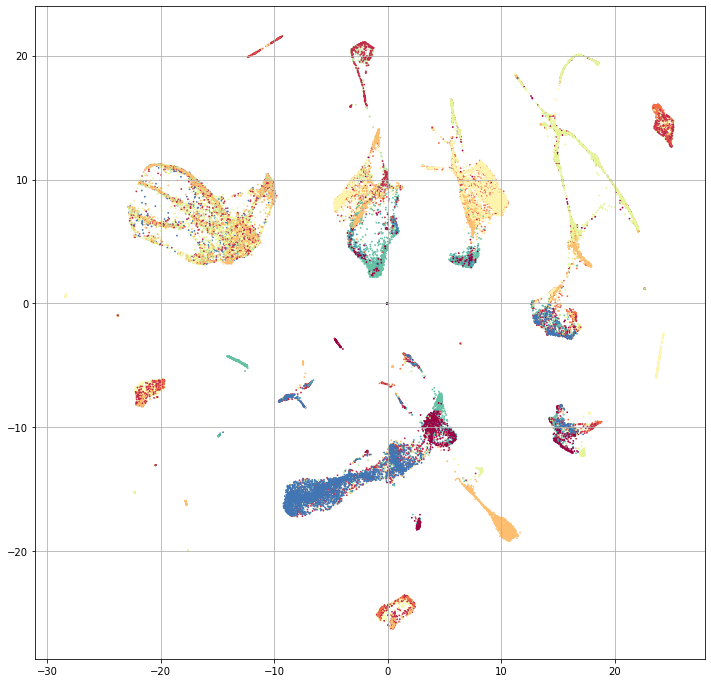

In [32]:
# visualize the embedding
fig, ax = plt.subplots(1, 1, figsize=(12,12))
ax.scatter(X_transformed[:, 0], X_transformed[:, 1], cmap="Spectral", c=adata[:].obs['tissue'].cat.codes, s=0.6)
plt.grid()

# TSNE

In [30]:
# from sklearn.manifold import TSNE

In [73]:
gindage=adata.obs['age']=='3m'

In [74]:
%%time
X_embedded = TSNE(n_components=2,perplexity=50,#learning_rate=1000., #learning_rate='auto',
                  init='random').fit_transform(asvd[gindage,:])

/home/ec2-user/anaconda3/envs/mxnet_latest_p37/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



CPU times: user 14min 27s, sys: 2min 43s, total: 17min 10s
Wall time: 2min 8s


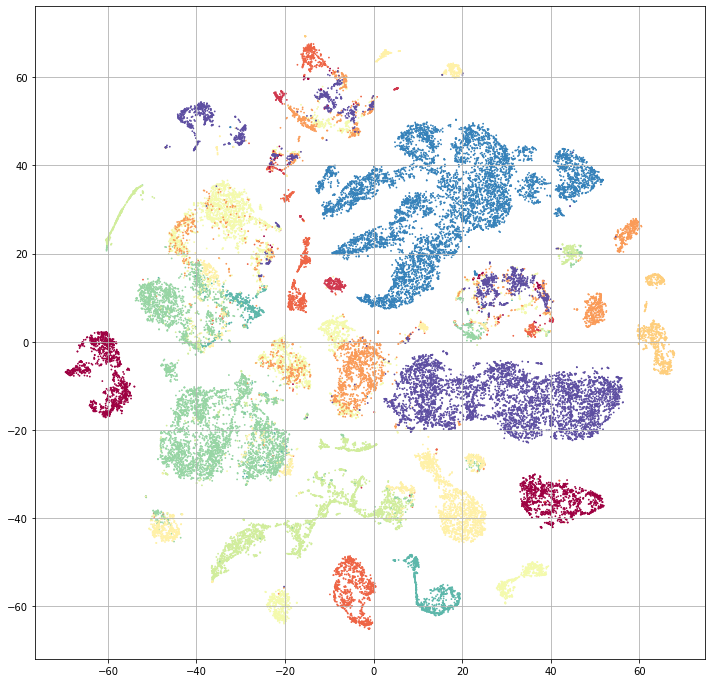

In [33]:
# visualize the embedding
fig, ax = plt.subplots(1, 1, figsize=(12,12))
ax.scatter(X_embedded[:, 0], X_embedded[:, 1], cmap="Spectral", c=adata[gindage].obs['tissue'].cat.codes, s=0.6)
# plt.colorbar()
ax.grid()
# fig.colorbar()

# MCML

In [50]:
!pip install -U MCML

     |████████████████████████████████| 24.8 MB 31.5 MB/s            
     |████████████████████████████████| 750.6 MB 8.3 kB/s              
     |████████████████████████████████| 11.3 MB 74.1 MB/s            
     |████████████████████████████████| 15.7 MB 67.4 MB/s            
  Attempting uninstall: numpy
    Found existing installation: numpy 1.20.1
    Uninstalling numpy-1.20.1:
      Successfully uninstalled numpy-1.20.1
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1
  Attempting uninstall: pandas
    Found existing installation: pandas 1.2.2
    Uninstalling pandas-1.2.2:
      Successfully uninstalled pandas-1.2.2
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/mxnet_latest_p37/bin/python -m pip install --upgrade pip' command.


In [31]:
# import torch

In [32]:
# torch.device(0)

In [33]:
mcml = MCML(n_latent = 50, epochs = 60)

In [34]:
%%time
latentMCML = mcml.fit(asvd[gindage,:], adata[gindage].obs['tissue'].cat.codes.values[np.newaxis,:] , fracNCA = 0.8 , silent = False) #Run MCML

====> Epoch: 0 Average loss: 0.7689
====> Epoch: 1 Average loss: 0.3957
====> Epoch: 2 Average loss: 0.3224
====> Epoch: 3 Average loss: 0.2860
====> Epoch: 4 Average loss: 0.2652
====> Epoch: 5 Average loss: 0.2523
====> Epoch: 6 Average loss: 0.2421
====> Epoch: 7 Average loss: 0.2355
====> Epoch: 8 Average loss: 0.2317
====> Epoch: 9 Average loss: 0.2280
====> Epoch: 10 Average loss: 0.2265
====> Epoch: 11 Average loss: 0.2239
====> Epoch: 12 Average loss: 0.2207
====> Epoch: 13 Average loss: 0.2206
====> Epoch: 14 Average loss: 0.2190
====> Epoch: 15 Average loss: 0.2161
====> Epoch: 16 Average loss: 0.2156
====> Epoch: 17 Average loss: 0.2140
====> Epoch: 18 Average loss: 0.2145
====> Epoch: 19 Average loss: 0.2134
====> Epoch: 20 Average loss: 0.2127
====> Epoch: 21 Average loss: 0.2115
====> Epoch: 22 Average loss: 0.2111
====> Epoch: 23 Average loss: 0.2108
====> Epoch: 24 Average loss: 0.2100
====> Epoch: 25 Average loss: 0.2090
====> Epoch: 26 Average loss: 0.2086
====> Epoch

In [35]:
latentMCML.shape

(40782, 50)

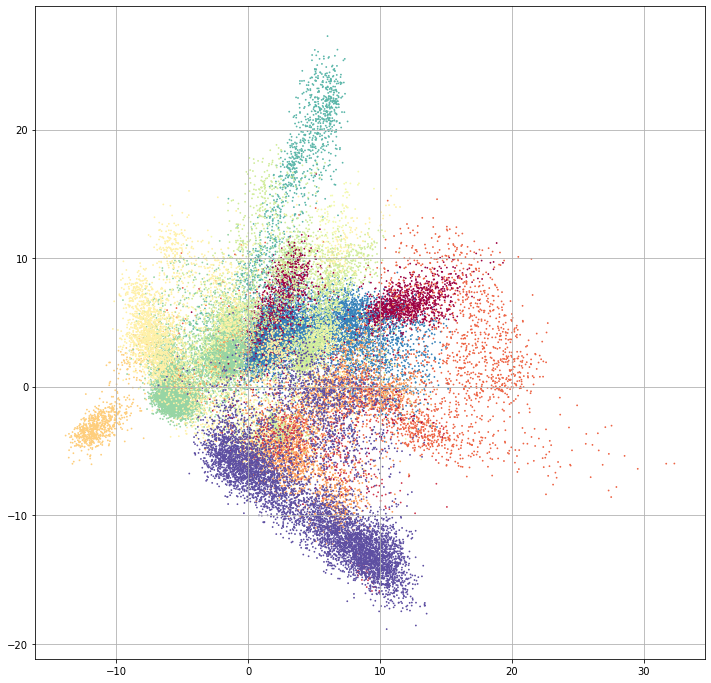

In [36]:
# visualize the embedding
fig, ax = plt.subplots(1, 1, figsize=(12,12))
ax.scatter(latentMCML[:, 0], latentMCML[:, 1], cmap="Spectral", c=adata[gindage].obs['tissue'].cat.codes, s=0.6)
# plt.colorbar()
ax.grid()
# fig.colorbar()

In [42]:
ageint = np.array([int(ii[:ii.find('m')]) for ii in adata.obs['age']])

In [43]:
# adata[gindage].obs['tissue']#.cat.codes.values

In [44]:
# dfdimred = pd.DataFrame(np.array([latentMCML[:, 0], latentMCML[:, 1], ageint[gindage]]))

In [45]:
# dfdimred

In [46]:
dfdimred = pd.DataFrame(np.array([latentMCML[:, 0], latentMCML[:, 1],latentMCML[:, 2], ageint[gindage],adata[gindage].obs['tissue'],.01*np.ones_like(ageint[gindage])]).T,
                           columns = ['dim1','dim2','dim3','age','tissue','size'])
# dfdimred.tissue

dfdimred

,dim1,dim2,dim3,age,tissue,size
0,2.314058,1.905902,4.238416,3,Tongue,0.01
1,5.693073,2.567568,-2.410666,3,Tongue,0.01
2,7.798136,2.712726,-5.206309,3,Tongue,0.01
3,1.239373,4.402728,1.156767,3,Tongue,0.01
4,2.064901,4.548916,4.514141,3,Tongue,0.01
...,...,...,...,...,...,...
40777,7.566279,-14.787463,-9.132878,3,Trachea,0.01
40778,3.477947,0.503476,-3.788979,3,Trachea,0.01
40779,1.217262,-6.854951,-7.057477,3,Trachea,0.01
40780,7.4845,0.564776,-3.969981,3,Trachea,0.01


In [47]:
import plotly

In [51]:
# plotly.express.colors.qualitative.Vivid_r

In [50]:
# import plotly.express as px
# # df = px.data.iris()

# # dfdimred = pd.DataFrame([X_transformed[:, 0], X_transformed[:, 1], ageint[:]])
# fig = px.scatter_3d(dfdimred, x='dim1', y='dim2', z='dim3',
#               color='tissue')#,color_discrete_sequence=plotly.express.colors.qualitative.Vivid_r)
# fig.show()

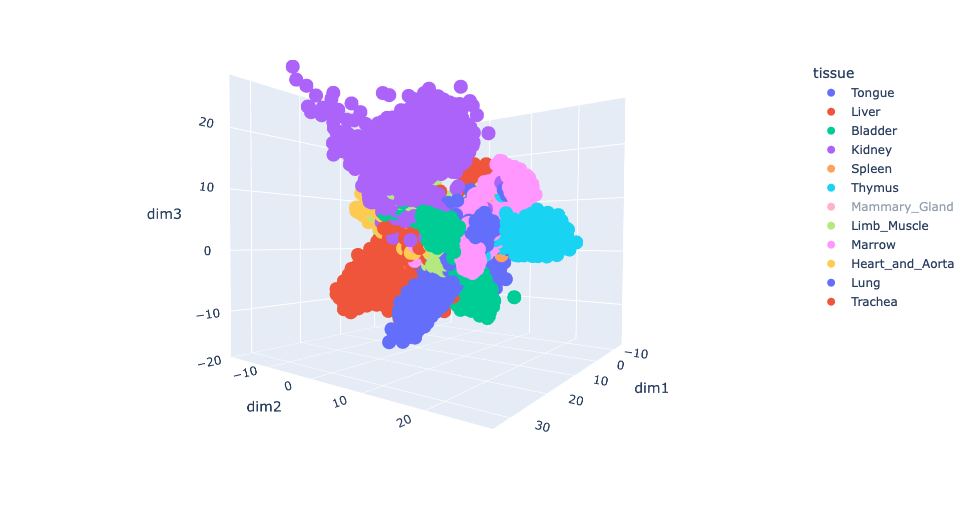